# 1. Importing the data from csv file and plotting glucose readings along with meal times


Total number of glucose readings is: 8047

Some of points may be missing, the above number represents the collected readings from start to end date

Remove NaN from the mg/dL column... 
Total actual number of glucose readings is: 7676

Remove NaN from the CHO so we can plot the points of meals...
Total number of meal times: 497

Some of the successive meal readings are redundant and stand for one meal only

Add succesive redundant meal readings (CHO, fat, protein) and store under one recording...

                   Date  mg/dL     CHO (g)    Fat (g)  Protein (g)
0   2008-08-04 17:41:00  126.0   92.260000  23.830000    14.780000
1   2008-08-05 05:31:00  126.0  194.720000  11.590000    35.830000
2   2008-08-05 07:01:00  103.0    0.000000   0.050000     0.280000
3   2008-08-05 09:56:00  108.0   26.950000   0.390000     1.290000
4   2008-08-05 12:21:00  105.0   70.240000   0.610000    12.370000
5   2008-08-05 13:56:00   94.0   28.160000   5.240000     2.620000
6   2008-08-05 14:41:00  11

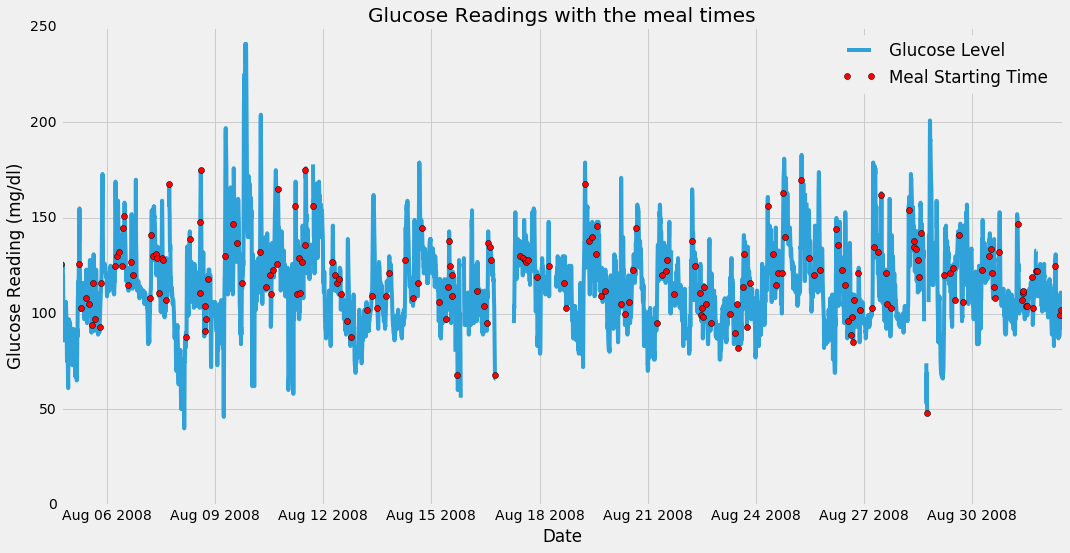

In [102]:
#This was written in Python 2, if you are running Python 3, use a code translation library

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#This is for the interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

#_DATA_DIR = r'/Users/Salim/Desktop/Diabetes Project/Input/input'
#_FIG_DIR = r'/Users/Salim/Desktop/Diabetes Project/figures'
_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P5.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P1 = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P1 = df_P1.sort(['Date'])

## Matplotlib Variables
_FIG_SIZE = (16, 8)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

#For printing full elements of dataframe or array
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

print "\nTotal number of glucose readings is:", df_P1['mg/dL'].size
print "\nSome of points may be missing, the above number represents the collected readings from start to end date"

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P1_wonan_mg = df_P1.dropna(subset=['mg/dL'])
print "\nRemove NaN from the mg/dL column...", "\nTotal actual number of glucose readings is:", df_P1_wonan_mg['mg/dL'].size

#Converting object type to float for all of the dataframe
df_P12= pd.DataFrame(df_P1_wonan_mg).convert_objects(convert_numeric=True)

print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_P12 = df_P12.dropna(subset=['CHO (g)'])
print "Total number of meal times:", df_P12['CHO (g)'].size

print "\nSome of the successive meal readings are redundant and stand for one meal only"

df_P12 = df_P12.reset_index(drop=True)

df_P1_meals = copy.deepcopy(df_P12)

print '\nAdd succesive redundant meal readings (CHO, fat, protein) and store under one recording...\n' 
row = 0

#Combine the successive meals: if the minute difference is 5 minutes then combine

i = 0   
while (i <= (df_P12['CHO (g)'].size-1)):
    row = row + 1 
    k = i
    #print "Meal time is:", df_P12.Date[i]
    #keep this row
    if (k == (df_P12['CHO (g)'].size-1)):
        i +=1
        break
    minutesdiff = df_P12.Date[k+1] - df_P12.Date[k]
    while ((minutesdiff.seconds / 60 == 5) and (k < df_P12['CHO (g)'].size-1)):
        #drop this row but add CHO and fats and proteins to values of previous row
        #print "add"
        k = k+1
        df_P1_meals.set_value(row-1,'CHO (g)',df_P1_meals['CHO (g)'][row-1]+df_P1_meals['CHO (g)'][row])
        df_P1_meals.set_value(row-1,'Fat (g)',df_P1_meals['Fat (g)'][row-1]+df_P1_meals['Fat (g)'][row])
        df_P1_meals.set_value(row-1,'Protein (g)',df_P1_meals['Protein (g)'][row-1]+df_P1_meals['Protein (g)'][row])
        df_P1_meals.drop(df_P1_meals.index[row], axis=0, inplace=True)
        df_P1_meals = df_P1_meals.reset_index(drop=True)
        if (k == (df_P12['CHO (g)'].size-1)):
            i == k + 1
            break   
        minutesdiff = df_P12.Date[k+1] - df_P12.Date[k]
#    row = row - 1
    i = k+1               

print_full(df_P1_meals)
    
#########This old method combined only the meals with same exact nutrients size, rather appraoch should be based on time increments
# count = 1
# for i, x in enumerate(df_P12['CHO (g)']):
#     if i > 0:
#         row = row + 1
#         if (i == (df_P12['CHO (g)'].size-1) and x == df_P12['CHO (g)'][i-1]):#checking if it is last element of the list
#             count += 1
#             df_P1_meals.drop(df_P1_meals.index[row], axis=0, inplace=True)
#             df_P1_meals = df_P1_meals.reset_index(drop=True)
#             df_P1_meals.set_value(row-1,'CHO (g)',df_P12['CHO (g)'][i-1]*count)
        
#         #if content of current element is same as previous, then delete row      
#         elif x == df_P12['CHO (g)'][i-1]:
#             count += 1
#             df_P1_meals.drop(df_P1_meals.index[row], axis=0, inplace=True)
#             df_P1_meals = df_P1_meals.reset_index(drop=True)
#             row = row - 1
            
#         #if next meal reading is different than the previous one    
#         else:
#             if(i == (df_P12['CHO (g)'].size-1)):
#                 df_P1_meals.set_value(row-1,'CHO (g)',df_P12['CHO (g)'][i-1]*count)
#                 df_P1_meals.set_value(row,'CHO (g)',df_P12['CHO (g)'][i])
#             else:
#                 df_P1_meals.set_value(row-1,'CHO (g)',df_P12['CHO (g)'][i-1]*count)
#                 #print "Current value is different than previous. Multiply previous by", count,"and result is:",df_P12['CHO (g)'][i-1]*count
#                 #print "this will be in the row index of:", row-1
#                 count = 1    
######

df_P1_meals = df_P1_meals.reset_index(drop=True)
print "There are", df_P1_meals['CHO (g)'].size, "recorded meal times.\n" 

print df_P1_meals.head()

plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df_P1.Date, df_P1['mg/dL'], '-', label="Glucose Level");
plt.plot_date(df_P1_meals.Date, df_P1_meals['mg/dL'], 'ro', label="Meal Starting Time")
plt.xlabel('Date')
plt.ylabel('Glucose Reading (mg/dl)')
plt.legend(loc='upper right')
title = 'Glucose Readings with the meal times'
plt.title(title);

In [103]:
def handle_case():
    print "This dataframe does not have missing glucose readings following any meal time"

# output to static HTML file
output_file("Raw_CGM.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P1.Date, df_P1['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P1_meals.Date, y=df_P1_meals['mg/dL'], z=df_P1_meals['CHO (g)'], k = df_P1_meals['Fat (g)'], d = df_P1_meals['Protein (g)']))

g1 = plot.asterisk(x=df_P1_meals.Date, y=df_P1_meals['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 


# Patient meal size histogram & Stats

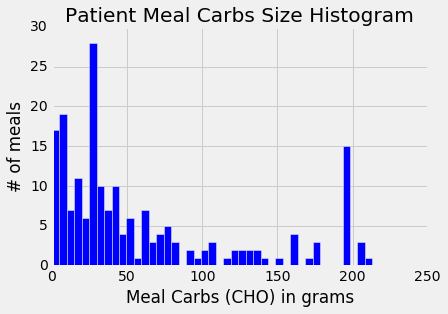

The meal Carbs mean is: 60.7249447722 grams with a std of: 61.4390377189 grams.


In [104]:
bins =  int(math.ceil(np.max(df_P1_meals['CHO (g)'])/5))#bins of 5 grams

n, bins, patches = plt.hist(df_P1_meals['CHO (g)'], bins, facecolor='blue', alpha=1)
plt.title('Patient Meal Carbs Size Histogram')
plt.xlabel('Meal Carbs (CHO) in grams')
plt.ylabel('# of meals')
plt.show()

print "The meal Carbs mean is:", np.mean(df_P1_meals['CHO (g)']), "grams with a std of:", np.std(df_P1_meals['CHO (g)']), "grams."

# Critical Assumptions for Cleaning Data

## 1. Assumption for Deletion

**a. Delete meal times that have several missing glucose readings and do not have a full glucose plot following them**

We may consider keeping these points later if we are interested on the meal times only and not the readings following them.

The window that is selected is under window_size. i.e: 23 represents a window of (23*5)+5 = 120 mintues

In [105]:
import datetime

df_P1_meals_w_deletion = copy.deepcopy(df_P1_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
window_size = 23 #This represents window size based on increments of 5.

del_points_df1 = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del1 = []

for x in range(df_P1_meals_w_deletion['CHO (g)'].size):
    a = df_P1_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(window_size):
        b += datetime.timedelta(minutes=incr)
        reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    if (count > ((window_size+1)/3)):
        print "\nThe meal time at", a, "has", count,"missing readings within its {}".format((window_size*5)+5),"minutes. Thus, it will be removed from the dataset.\n"
        #Put this into a dataframe to plot later with different color
        del_points_df1 = del_points_df1.append(df_P1.loc[df_P1['Date'] == a])        
        points_to_del1.extend([x])  

#Remove the above detected points from dataset
df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[points_to_del1],axis=0,inplace=True)
df_P1_meals_w_deletion = df_P1_meals_w_deletion.sort(['Date'])
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)

print "There are", df_P1_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings.\n" 

#print points_to_del1

print_full(df_P1_meals_w_deletion)


The meal time at 2008-08-07 15:26:00 has 16 missing readings within its 120 minutes. Thus, it will be removed from the dataset.


The meal time at 2008-08-16 18:21:00 has 19 missing readings within its 120 minutes. Thus, it will be removed from the dataset.


The meal time at 2008-08-18 06:16:00 has 20 missing readings within its 120 minutes. Thus, it will be removed from the dataset.

There are 191 remaining meal times recordings.

                   Date  mg/dL     CHO (g)    Fat (g)  Protein (g)
0   2008-08-04 17:41:00  126.0   92.260000  23.830000    14.780000
1   2008-08-05 05:31:00  126.0  194.720000  11.590000    35.830000
2   2008-08-05 07:01:00  103.0    0.000000   0.050000     0.280000
3   2008-08-05 09:56:00  108.0   26.950000   0.390000     1.290000
4   2008-08-05 12:21:00  105.0   70.240000   0.610000    12.370000
5   2008-08-05 13:56:00   94.0   28.160000   5.240000     2.620000
6   2008-08-05 14:41:00  116.0   12.000000   6.600000     1.400000
7   2008-08-05 15:51:00   

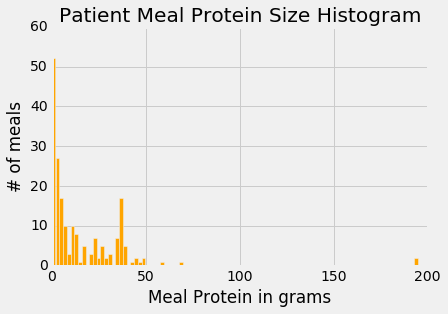

The meal Protein mean is: 15.4311111927 grams with a std of: 23.6319462899 grams.


In [106]:
bins =  int(math.ceil(np.max(df_P1_meals['Protein (g)'])/2))#bins of 5 grams

n, bins, patches = plt.hist(df_P1_meals['Protein (g)'], bins, facecolor='orange', alpha=1)
plt.title('Patient Meal Protein Size Histogram')
plt.xlabel('Meal Protein in grams')
plt.ylabel('# of meals')
plt.show()

print "The meal Protein mean is:", np.mean(df_P1_meals['Protein (g)']), "grams with a std of:", np.std(df_P1_meals['Protein (g)']), "grams."

**The dataframe that contains the meal times to be deleted after this assumption is: del_points_df1**



**b. Delete meal times which all following readings are decreasing or have no sign of a significant increase (i.e: 15mg/dl).**

For every glucose reading starting few minutes before the meal was recorded, just in case the meal was recorded minutes later after food intake, we check if there is a significant increase in **its** following "glucose_effect_window" (i.e 45 minutes).

For instance, a reading situated 30 minutes after meal time recording which has a following glucose increase of (15mg/dl in total) after 30minutes will result on keeping that original meal time which was (30mins + 30mins before). Hence, this is a loose assumption but we can make it stricter by changing window variables and increase glucose value.

If no significant increase is apparent, we delete the meal point.


In [107]:
#Note: Make sure to run the previous cell before running this one since the dataframe here used will be overwitten at end of this cell

#variables
incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
gl_increase_window = 45 #Minutes from the instance where the glucose is reflected on the blood to significant increase###Change this to higher minutes if glucose increases slowly
pre_recording_mins = 10 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 20 #20mg/dL increase because we are interested in meals for now, later we can include sncaks

########May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level############
meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr, incr)]

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]

points_to_del = []
del_points_df = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will go to take a significant increase, not necessarily the very lowest points
high_surrounding_gl = pd.DataFrame()
offset_low_point_to_meal = []

for x, item in enumerate(df_P1_meals_w_deletion['Date']):
    
    #a = df_P1_meals_w_deletion['Date'][x]
    meal_reading = df_P1.loc[df_P1['Date'] == item]['mg/dL']
    b = item - datetime.timedelta(minutes=pre_recording_mins) 
    keep = 0
    
    for i in meal_affect_window:
        current_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue
            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue      
            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P1.loc[df_P1['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >gl_increase):
                #print "We should keep this reading"
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P1.loc[df_P1['Date'] == b])
                high_surrounding_gl = high_surrounding_gl.append(df_P1.loc[df_P1['Date'] == c])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<=item):
                    offset_low_point_to_meal.extend([int(-(item-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-item).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                #offset_low_point_to_meal.extend([offset_seconds])
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
        if (i == meal_affect_window[-1]):
            #print "The meal reading taken at" ,a, "should be deleted."
            #Put this into an dataframe to plot with different color
            del_points_df = del_points_df.append(df_P1.loc[df_P1['Date'] == item])
            #Also remove this from dataset   
            points_to_del.extend([x])                     

#print "\nThe dataframe of the points to be deleted is:\n", del_points_df 

#print (points_to_del)

print "\nThere are", len(points_to_del), "meal recordings that will be deleted."

df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[points_to_del],axis=0,inplace=True)
df_P1_meals_w_deletion = df_P1_meals_w_deletion.sort(['Date'])
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)

print "\nThere are", df_P1_meals_w_deletion['CHO (g)'].size, "remaining meal times recordings." 

low_surrounding_gl = low_surrounding_gl.sort(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

high_surrounding_gl = high_surrounding_gl.sort(['Date'])
high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)


There are 83 meal recordings that will be deleted.

There are 108 remaining meal times recordings.


**The dataframe that contains the meal times to be deleted after this assumption is: del_points_df**

**In the below interactive Bokeh plotting: Plotting all the meal points along with the ones to be deleted with different colors.**


In [54]:
def handle_case():
    print "This dataframe does not have missing glucose readings following any meal time"

# output to static HTML file
output_file("All_Data_with_Deletion.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P1.Date, df_P1['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P1_meals_w_deletion.Date, y=df_P1_meals_w_deletion['mg/dL'], z=df_P1_meals_w_deletion['CHO (g)'], k = df_P1_meals_w_deletion['Fat (g)'], d = df_P1_meals_w_deletion['Protein (g)']))
#glyph_1 = Asterisk(x="x", y="y", line_color="#f0027f", fill_color=None, line_width=8)
#g1 = plot.add_glyph(good_readings, glyph_1)

g1 = plot.asterisk(x=df_P1_meals_w_deletion.Date, y=df_P1_meals_w_deletion['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

if (len(points_to_del1) == 0):
    handle_case()
else: 
#     delete_readings_1a = ColumnDataSource(dict(x=del_points_df1.Date, y=del_points_df1['mg/dL'], z=del_points_df1['CHO (g)'], k = del_points_df1['Fat (g)'], d = del_points_df1['Protein (g)']))
#     glyph_2 = Asterisk(x="x", y="y", line_color="#32CD32", fill_color=None, line_width=8)
#     g2 = plot.add_glyph(delete_readings_1a, glyph_2)
    plot.asterisk(x=del_points_df1.Date, y=del_points_df1['mg/dL'],legend = 'To be deleted after Assumption 1.a', line_color="#32CD32", fill_color=None, line_width=8)

if (len(points_to_del) == 0):
    handle_case()
else:        
#      delete_readings_1b = ColumnDataSource(dict(x=del_points_df.Date, y=del_points_df['mg/dL'], z=del_points_df['CHO (g)'], k = del_points_df['Fat (g)'], d = del_points_df['Protein (g)']))
#      glyph_3 = Asterisk(x="x", y="y", line_color="#0404B4", fill_color=None, line_width=8)
#      g3 = plot.add_glyph(delete_readings_1b, glyph_3)
     plot.asterisk(x=del_points_df.Date, y=del_points_df['mg/dL'],legend = 'To be deleted after Assumption 1.b', line_color="#0404B4", fill_color=None, line_width=8)

# plot.asterisk(legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8)
# plot.asterisk(legend = 'To be deleted after Assumption 1.a', line_color="#32CD32", fill_color=None, line_width=8)
# plot.asterisk(legend = 'To be deleted after Assumption 1.b', line_color="#0404B4", fill_color=None, line_width=8)

#plot.asterisk(x=high_surrounding_gl.Date, y=high_surrounding_gl['mg/dL'], legend = 'first increase Points', line_color="#32CD32", fill_color=None, line_width=8)   
#plot.asterisk(x=low_surrounding_gl.Date, y=low_surrounding_gl['mg/dL'], legend = 'first low Points', line_color="#0404B4", fill_color=None, line_width=8)   

#print y
plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 


**This completes the assumptions for deleting abnormal meal points**

## 2. Assumption for Adjusting Meal times: Finding surrounding lowest glucose levels

Extract lowest glucose reading surrounding the meal time, this is usually the point of glucose increase effect after meal. The window can be a variable, we are using [-20mins to +45mins] of the meal time.

By extracting these points, we can estimate that the true meal times happened few minutes right before these points (usually 0 mins to 30 mins before) -- This latter assumption (of this sentence) is not used anywhere but may be used for plotting.

**Finding the lowest glucose level surrounding the recorded meal time**

1. Find a significant blood glucose increase surrounding the recorded meal time, say 15mg/dl. / Already done in previous deletion task

2. Find the lowest point before that increase. That's what we will consider in our future processing. / Already done in previous deletion task

3. Need to find surrounding lowest point next to low point previously found. Since the low point previously found can be 20mins before meal, we start search here from that point and forward.

**Below is the dataframe that contains low glucose levels surrounding meal times, which have a significant following glucose increase.** Not only the surrounding lowest readings, but it must have a **nearby** glucose increase to it.

In [55]:
gl_rise_window = [j for j in np.arange(0, gl_increase_window+incr, incr)]

offset_lowest_point_to_meal = []
highpoints_after_meal = []
points_to_readjust = []

readjust_points_df = pd.DataFrame()
surrounding_lowest_points_df = pd.DataFrame()
surrounding_high_points_df = pd.DataFrame()

print "Readjusting surrounding lowest meal points..."
print "\nSurrounding lowest meal points are saved under --> surrounding_lowest_points_df"
for x,a in enumerate(low_surrounding_gl['Date']):
    b = a
    min_reading = df_P1.loc[df_P1['Date'] == a]['mg/dL']
    lowest_pt_index = 0
    highest_pt_index = 0
    #print "The surrounding low value has a date of", a
    for i,y in enumerate(gl_rise_window):
        #get the lowest point within the full window
        current_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'].values[0]
        try:
            current_reading
        except IndexError:
            print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue
        
        if (math.isnan(current_reading)):
            b += datetime.timedelta(minutes=incr)  
            continue
            
        #print "The current lowest reading is:", min_reading.values[0], "and compared reading is:", current_reading, "and y is:", y
        if (current_reading<min_reading.values[0]): 
            c = b  
            for k in compare_window:#comparing the point with its following readings in compare window size
                c += datetime.timedelta(minutes=incr)
                compare_reading = df_P1.loc[df_P1['Date'] == c]['mg/dL']
                if ((compare_reading.values[0] - current_reading) >gl_increase):
                    #print "Readjusting the lowest meal point at date", a, "whihch has a glucose of", df_P1.loc[df_P1['Date'] == a]['mg/dL'].values[0], "with the point at date", b, "which has a glucose reading of", df_P1.loc[df_P1['Date'] == b]['mg/dL'] .values[0]

                    min_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'] 
                    lowest_pt_index = y
                    
                    #we will use these points to find the actaul peak
                    high_surrounding_gl.drop(high_surrounding_gl.index[x],axis=0,inplace=True) 
                    high_surrounding_gl = high_surrounding_gl.append(df_P1.loc[df_P1['Date'] == c])
                    high_surrounding_gl = high_surrounding_gl.sort(['Date'])
                    high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)
                    break

        b += datetime.timedelta(minutes=incr) 
    #print x,": At date", a, "the lowest point is", min_reading.values[0], "of index", lowest_pt_index, "and the highest point is", max_reading.values[0], "of index",highest_pt_index 
    offset_lowest_point_to_meal.extend([lowest_pt_index])

    surrounding_lowest_points_df = surrounding_lowest_points_df.append(df_P1.loc[df_P1['Date'] == (a + datetime.timedelta(minutes=int(lowest_pt_index)))]) 
    surrounding_high_points_df = surrounding_high_points_df.append(df_P1.loc[df_P1['Date'] == (a + datetime.timedelta(minutes=int(lowest_pt_index)))]) 
    
surrounding_lowest_points_df = surrounding_lowest_points_df.sort(['Date'])
surrounding_lowest_points_df = surrounding_lowest_points_df.reset_index(drop=True)

#The real time difference between the lowest point and meal time is the addition of difference between meal time and low surrounding point + between low surrounding point and lowest surrounding point
        
offset_meal2increase = np.add(offset_lowest_point_to_meal , offset_low_point_to_meal)    
    
#print offset_meal2increase

print "\nThe mean of the time elapsed between recorded meal time and convenient surrounding lowest point is %.2f" %np.mean(offset_meal2increase), "minutes \nwith a std of %.2f" %np.std(offset_meal2increase), "minutes."

min_minutes = np.absolute(np.min(offset_meal2increase))
max_minutes = np.max(offset_meal2increase)

# n, bins, patches = plt.hist(offset_meal2increase, (min_minutes+max_minutes)/5, facecolor='blue', alpha=1)
# plt.title('Minutes between recorded meal time and lowest point with glucose increase')
# plt.xlabel('Minutes')
# plt.ylabel('# of meals')
# plt.show()


#print "size of low meal points is:", low_surrounding_gl['Date'].size
#print "size of high meal points is:", high_surrounding_gl['Date'].size

Readjusting surrounding lowest meal points...

Surrounding lowest meal points are saved under --> surrounding_lowest_points_df

The mean of the time elapsed between recorded meal time and convenient surrounding lowest point is 3.93 minutes 
with a std of 20.11 minutes.


In [56]:
#Last non empty row of patient data
nonempty_P1_readings = df_P1[pd.notnull(df_P1['Date'])]

#print nonempty_P1_readings.iloc[-1,nonempty_P1_readings.columns.get_loc('Date')]


**The dataframe that contains the meal times after deletion of abnormal meal recordings is: df_P1_meals_w_deletion**

**The dataframe that contains the lowest surrounding points with significant glucose increase is: surrounding_lowest_points_df**

# Detecting peaks following meal times

Steps:

1. Detect a significant glucose decrease

2. Find the highest glucose point up to that decrease


In [57]:
#Step 1

gl_decrease = 15 #15mg/dl of glucose drop (we noticed from the data that 10mg/dl would be too low and may result in not finding the highest peak after meal)

minutes2peak = 60#Minutes to reach the peak after meal
gl_decrease_window = 120 #Minutes it takes for a significant glucose decrease after meal, it may take long time for glucose to go down, few hours

up2peak_window = [j for j in np.arange(0, minutes2peak+incr, incr)]
compare_window = [j for j in np.arange(incr, gl_decrease_window+incr, incr)]

#print up2peak_window

afterpeak_lowgl_df = pd.DataFrame()#This dataframe contains the points after the glucose drop following the peak
lowpoint_to_del_df = pd.DataFrame()#Dataframe contaning any meal recording to be deleted because they do not have a significant nearby glucose drop after the increase
peak_points_df = pd.DataFrame()#Dataframe containing peak points following meal times
lowpoint_to_del = []

for x, item in enumerate(high_surrounding_gl['mg/dL']):   
    a = high_surrounding_gl['Date'][x]   
    keep = 0
    b= a

    for i in up2peak_window:

        current_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
        #print "**Following reading:", current_reading.values[0], "at the date of", b          
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P1.loc[df_P1['Date'] == c]['mg/dL']
            #print "***Compared reading reading:", compare_reading.values[0], " at the date of", c  
            if ((current_reading.values[0] - compare_reading.values[0]) > gl_decrease):#significant glucose drop has been detected
                #Store this reading on a dataframe of points detecting glucose drop after peak
                #print "found it"
                afterpeak_lowgl_df = afterpeak_lowgl_df.append(df_P1.loc[df_P1['Date'] == c])
                keep = 1
                break
                
        if (keep == 1):
            break   
    
        if (i == up2peak_window[-1]):
            print "Could not detect a significant glucose drop after this meal recording", df_P1_meals_w_deletion['Date'][x], ". It is suggested to delete it"  
            lowpoint_to_del.extend([x])  
            lowpoint_to_del_df = lowpoint_to_del_df.append(df_P1.loc[df_P1['Date'] == a])
            
        b += datetime.timedelta(minutes=incr)    

#Drop x from the "all the meals" dataframe and lowest surrounding dataframe as well
df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[lowpoint_to_del],axis=0,inplace=True)  
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)
 

surrounding_lowest_points_df.drop(surrounding_lowest_points_df.index[lowpoint_to_del],axis=0,inplace=True)  
surrounding_lowest_points_df = surrounding_lowest_points_df.reset_index(drop=True)

offset_meal2increase = [item for index, item in enumerate(offset_meal2increase) if index not in lowpoint_to_del] 
#print "offset_meal2increase size is:", len(offset_meal2increase)

afterpeak_lowgl_df = afterpeak_lowgl_df.reset_index(drop=True)
lowpoint_to_del_df = lowpoint_to_del_df.reset_index(drop=True)

#print "number of meals are:", df_P1_meals_w_deletion['CHO (g)'].size

#print "afterpeak_lowgl_df size is:", afterpeak_lowgl_df['CHO (g)'].size

#Step 2

#print "\nThe dataframe of the points after detecting a glucose drop:\n", afterpeak_lowgl_df 
def drange(start, stop, step):
    while start <= stop:
            yield start
            start += step
            
#print df_P1.iloc[-2]['Date']
    
for x, item in enumerate(afterpeak_lowgl_df['mg/dL']):
    #print "At the meal of date", df_P1_meals_w_deletion['Date'][x], "the lowest point is at:", surrounding_lowest_points_df['Date'][x] , "and low after peak is at:", afterpeak_lowgl_df['Date'][x]  
    meal_recording = df_P1_meals_w_deletion['Date'][x]
    #print "x is:", x , "and its date is:", afterpeak_lowgl_df['Date'][x]   
    a = surrounding_lowest_points_df['Date'][x]   
    current_reading = df_P1.loc[df_P1['Date'] == a]['mg/dL'].values[0]
    lowpt_after_peak = afterpeak_lowgl_df['Date'][x]   
    b= a
    #difference in minutes between lowest point and the point after glucose drop following peak
    window_peak = (lowpt_after_peak-a).seconds / 60
    #print window_peak
    peak_index = 0

    for i in drange(5,window_peak,5):        
        b += datetime.timedelta(minutes=incr)
        if (b <= nonempty_P1_readings.iloc[-1,nonempty_P1_readings.columns.get_loc('Date')]):
            incrt_reading = df_P1.loc[df_P1['Date'] == b]['mg/dL'].values[0]   
            if (math.isnan(incrt_reading)):
                b += datetime.timedelta(minutes=incr)  
                continue

            if (incrt_reading > current_reading):
                current_reading = incrt_reading
                peak_index = i
    #print "the peak index is offseted by", peak_index, "minutes from the lowest reading"        
    c = a + datetime.timedelta(minutes=int(peak_index))
    
    peak_points_df = peak_points_df.append(df_P1.loc[df_P1['Date'] == c])

surrounding_lowest_points_df = surrounding_lowest_points_df.reset_index(drop=True) 

peak_points_df = peak_points_df.reset_index(drop=True)

#print_full(peak_points_df['Date'])  

#print_full(surrounding_lowest_points_df)

#print peak_points_df 
peak_elapsed_time = []

#Need to make list with elapsed time between peak and meal recording for plotting, in minutes
for x, item in enumerate(peak_points_df['mg/dL']): 
    meal_recording = df_P1_meals_w_deletion['Date'][x]
    peak_reading = peak_points_df['Date'][x]      
    if (peak_reading>=meal_recording):
        topeakduration = (peak_reading-meal_recording).seconds / 60
    else:
        topeakduration = -(meal_recording-peak_reading).seconds / 60       
    peak_elapsed_time.append(int(topeakduration))
    
print "There are", surrounding_lowest_points_df['Date'].size, "remaining readings."


Could not detect a significant glucose drop after this meal recording 2008-08-16 13:06:00 . It is suggested to delete it
Could not detect a significant glucose drop after this meal recording 2008-08-29 12:16:00 . It is suggested to delete it
There are 105 remaining readings.


What a two recorded meals are close to each other, only few minutes apart. Usually, the first would still be affecting the glucose increase and the second will add more to that increase. Thus, we will combine the first and second into one and considered it as if it was recorded at the first recording. This is only if they are 60 minutes or less apart (The 60 minutes can be a variable).

1. Detect the peak points of the same date.

2. Add the meals of those dates.

3. Keep the first one and delete rest.

In [58]:
print "For meal recordings that are close enough and end up having the same peak, remove the latest and keep the first. However, add the meal sizes together.\n\n"

remove_index = peak_points_df['Date'].size #setting this to some value it will never be so we can overwrite it later
remove_pts = []
for i in range(peak_points_df['Date'].size):
    if ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index)):
        print "There are succesive meal readings which have the same peak.", "The dates of the two readings are:", df_P1_meals_w_deletion['Date'][i], "and", df_P1_meals_w_deletion['Date'][i+1]
        total_mealCHO = df_P1_meals_w_deletion['CHO (g)'][i] + df_P1_meals_w_deletion['CHO (g)'][i+1]
        total_mealfat = df_P1_meals_w_deletion['Fat (g)'][i] + df_P1_meals_w_deletion['Fat (g)'][i+1]
        total_mealProtein = df_P1_meals_w_deletion['Protein (g)'][i] + df_P1_meals_w_deletion['Protein (g)'][i+1]
        
        #Need to replace main dataframe containing the meal times, replace the row with the new meal sizes
        df_P1_meals_w_deletion.set_value(i, 'CHO (g)', total_mealCHO)
        df_P1_meals_w_deletion.set_value(i, 'Fat (g)', total_mealfat)
        df_P1_meals_w_deletion.set_value(i, 'Protein (g)', total_mealProtein)
        
        remove_index = i+1
        remove_pts.append(remove_index)
#remove the next rows with the same peak points from all the dataframes
df_P1_meals_w_deletion.drop(df_P1_meals_w_deletion.index[remove_pts], axis=0,inplace=True)
df_P1_meals_w_deletion = df_P1_meals_w_deletion.sort(['Date'])
df_P1_meals_w_deletion = df_P1_meals_w_deletion.reset_index(drop=True)

surrounding_lowest_points_df.drop(surrounding_lowest_points_df.index[remove_pts], axis=0,inplace=True)
surrounding_lowest_points_df = surrounding_lowest_points_df.sort(['Date'])
surrounding_lowest_points_df = surrounding_lowest_points_df.reset_index(drop=True)

peak_points_df.drop(peak_points_df.index[remove_pts], axis=0,inplace=True)
peak_points_df = peak_points_df.sort(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

#print "remove points list is:", remove_pts

#print "offset_meal2increase is", offset_meal2increase, "of the size", len(offset_meal2increase)

    #when we delete we change index so change this
for i in range(len(remove_pts)):
    index = remove_pts[i]
    #print "offset_meal2increase[index]", offset_meal2increase[index-i]
    del offset_meal2increase[index-i]
    del peak_elapsed_time[index-i]

print "There are ", df_P1_meals_w_deletion['Date'].size, "meals remaining."


For meal recordings that are close enough and end up having the same peak, remove the latest and keep the first. However, add the meal sizes together.


There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-05 13:56:00 and 2008-08-05 14:41:00
There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-05 19:11:00 and 2008-08-05 20:21:00
There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-06 10:21:00 and 2008-08-06 10:51:00
There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-07 05:01:00 and 2008-08-07 05:41:00
There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-08 13:51:00 and 2008-08-08 14:11:00
There are succesive meal readings which have the same peak. The dates of the two readings are: 2008-08-08 17:06:00 and 2008-08-08 17:36:00
There are suc

# Interactive plot of final meal recordings & increase points & peak points

In [59]:
# output to static HTML file
output_file("Data_Cleaned.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Data Cleaned Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P1.Date, df_P1['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P1.Date, df_P1['mg/dL'], fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P1_meals_w_deletion.Date, y=df_P1_meals_w_deletion['mg/dL'], z=df_P1_meals_w_deletion['CHO (g)'], k = df_P1_meals_w_deletion['Fat (g)'], d = df_P1_meals_w_deletion['Protein (g)']))
# glyph_1 = Asterisk(x="x", y="y", line_color="#f0027f", fill_color=None, line_width=8)
# g1 = plot.add_glyph(good_readings, glyph_1)
# plot.asterisk(legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8)

g1 = plot.asterisk(x=df_P1_meals_w_deletion.Date, y=df_P1_meals_w_deletion['mg/dL'],legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source = good_readings)


plot.asterisk(x=surrounding_lowest_points_df.Date, y=surrounding_lowest_points_df['mg/dL'], legend = 'Increasing Points', line_color="#32CD32", fill_color=None, line_width=8)   

plot.asterisk(x=peak_points_df.Date, y=peak_points_df['mg/dL'], legend = 'Peaks', line_color="#FFA500", fill_color=None, line_width=8)


plot.add_tools(HoverTool(renderers=[g1], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

# Plotting: Actual meal time recordings & Surrounding lowest points.

1. Plot until next meal only

2. Plot until there is a significant increase of glucose

Finding the points where the glucose starts to increase after the peak, so we stop the plot at that point

In [60]:
nonempty_readings = df_P1[pd.notnull(df_P1['Date'])]
last_row_date = nonempty_readings.iloc[-1, nonempty_readings.columns.get_loc('Date')]
#print last_row_date

gl_2nd_increase = 15 #second increase of 10mg/dl
after_reading = 300 #size of the plot after meal time in minutes
stop_plot_date = []

#print "surrounding_lowest_points_df size is ", surrounding_lowest_points_df['Date'].size

for x in range(surrounding_lowest_points_df['Date'].size):
    #print "Elapsed time from meal to peak is", peak_elapsed_time[x]
    stop = 0
    peak_gl_Date = peak_points_df['Date'][x]
    for d in drange(5,(after_reading-peak_elapsed_time[x]), 5):
     
        #current glucose level
        peak_gl_Date += datetime.timedelta(minutes=incr) 
        if ((peak_gl_Date - last_row_date).days >= 0 and (peak_gl_Date - last_row_date).seconds > 0):
            break
        
        current_gl_Date = peak_gl_Date
        compared_gl_date = peak_gl_Date
        current_gl = df_P1.loc[df_P1['Date'] == current_gl_Date]['mg/dL'].values[0] 
        
        for l in drange(5, gl_increase_window, 5):
            compared_gl_date += datetime.timedelta(minutes=incr)
            #print "compared_gl_date is", compared_gl_date, "and the difference is in days", (compared_gl_date - last_row_date).days, "and in seconds",(compared_gl_date - last_row_date).seconds 
            if ((compared_gl_date - last_row_date).days >= 0 and (compared_gl_date - last_row_date).seconds > 0):
                #print "Reached end"
                break
            else:    
                compared_gl = df_P1.loc[df_P1['Date'] == compared_gl_date]['mg/dL'].values[0]  
###            
            if (compared_gl - current_gl > gl_2nd_increase):
                #Find lowest point between current_gl and compared_gl
                lowest2nd_pt = current_gl
                lowest2nd_pt_date = current_gl_Date
                current_gl_temp_date = current_gl_Date
                for s in drange (5,(compared_gl_date - current_gl_Date).seconds / 60,5):
                    current_gl_temp_date += datetime.timedelta(minutes=incr)
                    current_gl_temp = df_P1.loc[df_P1['Date'] == current_gl_temp_date]['mg/dL'].values[0]  
                    if (current_gl_temp < lowest2nd_pt):
                        lowest2nd_pt = current_gl_temp
                        lowest2nd_pt_date = current_gl_temp_date
                stop = 1
                #Need to stop the plot at this current_gl date, so let's save it
                break
        if (stop == 1):
            #print "Stop here", current_gl_Date
            stop_plot_date.append(lowest2nd_pt_date)
            break
        if (d == after_reading-peak_elapsed_time[x]):
            #print "All the way"
            stop_plot_date.append(current_gl_Date)

#print stop_plot_date[1]    

In [61]:
print "the length of the stop_plot_date is", len(stop_plot_date)

print "the size of meals is", df_P1_meals_w_deletion['CHO (g)'].size

print "the size of surrounding_lowest_points_df is", surrounding_lowest_points_df['CHO (g)'].size



Plot_window = [i for i in np.arange(-(pre_recording_mins), after_reading+incr, incr)]

#This includes all steps for correct plotting
def Plot_extraction_v2(df_P1_w_all_deletion, df_all_plots_v2):
    for x in range(df_P1_w_all_deletion['CHO (g)'].size):
        #save the readings surrounding every meal time in a new dataframe
        a = df_P1_w_all_deletion['Date'][x]
        
        #Check if it's last reading
        if (x<((df_P1_w_all_deletion['CHO (g)'].size))-1):
            a1 = df_P1_w_all_deletion['Date'][x+1]          
            
            #c is the date from the dataframe that contains where glucose starts increasing again AFTER the peak
                      
            b = a - datetime.timedelta(minutes=pre_recording_mins)
            reading_list = []
            for j in Plot_window:
                reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']
                c = stop_plot_date[x]  #Stop at this date because there is another glucose increase right after it       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)   
                    continue
                #Check to include points only up to next meal time, else put nan on that array so they are not plotted
                if ((a1 - b).total_seconds() < 0 ):#readings_distance = (a1 -a).total_seconds()/60 #The elapsed time in minutes 
                    #print "Elapsed time on this iteration is less than the full window time", x
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue
                elif((c - b).total_seconds() < 0 ):    
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)
                    continue                  
                else:
                    #store this value on the jth column of xth row of the new dataframe
                    reading_list.append(reading.values[0])
                    b += datetime.timedelta(minutes=incr)
        else: 
            #plot readings until next meal, need to replace that row
            b = a - datetime.timedelta(minutes=pre_recording_mins)
            reading_list = []
            for j in Plot_window:
                reading = df_P1.loc[df_P1['Date'] == b]['mg/dL']       
                try:
                    reading.values[0]
                except IndexError:
                    #print "Index out of range"
                    reading_list.append(float('nan'))
                    b += datetime.timedelta(minutes=incr)   
                    continue
                #store this value on the jth column of xth row of the new dataframe
                reading_list.append(reading.values[0])
                b += datetime.timedelta(minutes=incr)
        #print reading_list
        #print df_all_plots.shape
        df_all_plots_v2.loc[x]=reading_list

    #print df_all_plots_v2

the length of the stop_plot_date is 90
the size of meals is 90
the size of surrounding_lowest_points_df is 90


In [62]:
def plotting(df_all_plots_v2, df_P1_w_all_deletion):
   
    plt.figure(figsize=(20,12))
    for j in range(0,5):
    #for j in range(len(df_P1_w_all_deletion)):
        row = df_all_plots_v2.iloc[j]
        row.plot(label='')
        #row.plot(label='Meal Time at {}'.format(df_P1_w_all_deletion['Date'][j]))
        
        if (j==0):
            #Recorded meal time reading
            plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=10, label ='Meal Recordings')
            #Lowest surrounding point of increase

            plt.plot(offset_meal2increase[j], surrounding_lowest_points_df['mg/dL'][j], 'b^', markersize=15, label ='Glucose Increase Points')
            plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=20, label ='Glucose Peaks')
        else:
            plt.plot(0, df_all_plots_v2[0][j], 'ro', markersize=10)
            plt.plot(offset_meal2increase[j], surrounding_lowest_points_df['mg/dL'][j], 'b^', markersize=15)
            plt.plot(peak_elapsed_time[j], peak_points_df['mg/dL'][j], 'y*', markersize=20)      
        

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    plt.legend(loc='upper right')
    title = 'Glucose Lelvel Readings {} minutes after meal recording or until next meal recording'.format(after_reading)
    plt.title(title);

    #Uncomment below to save plot
    #plt.savefig('Patient_1_Plotsaftermeal_iter0to5.png')

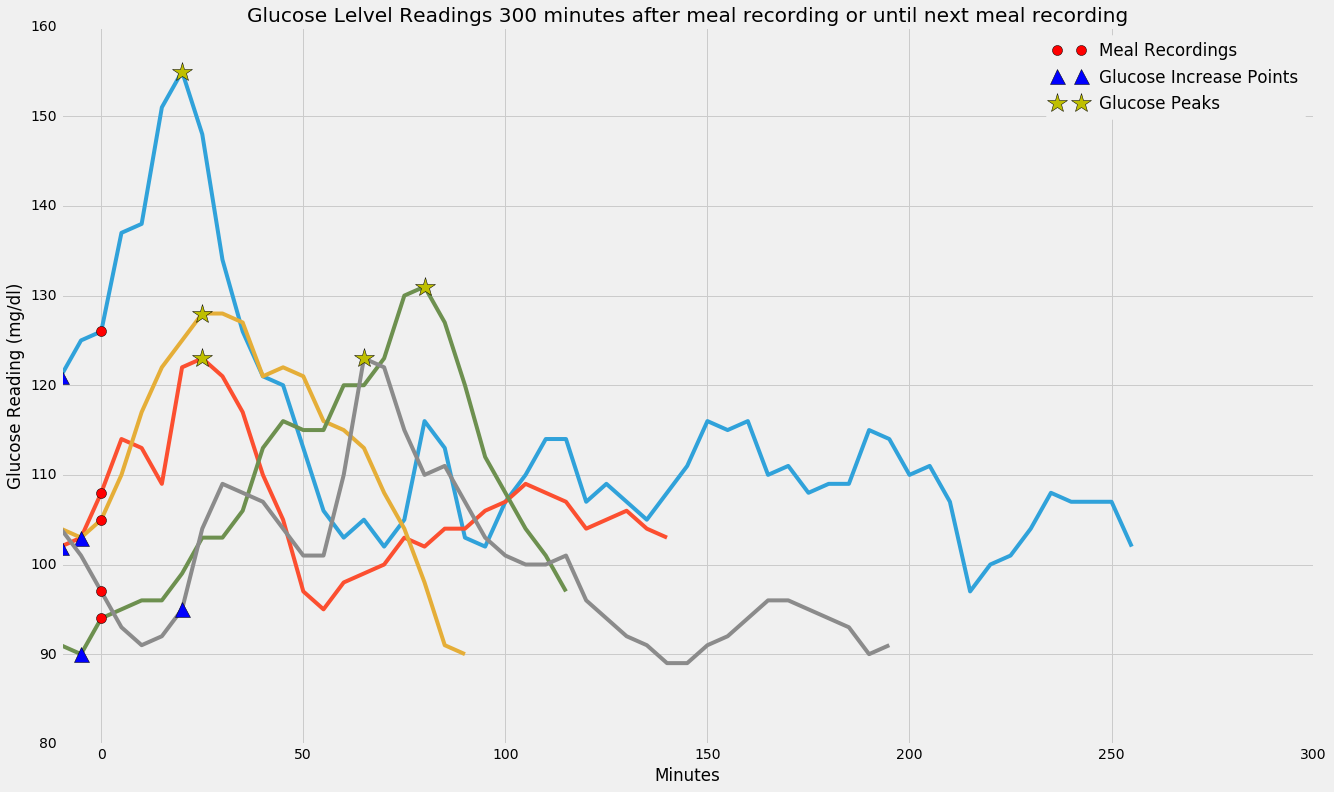

In [63]:
df_all_plots_v2 = pd.DataFrame(columns=Plot_window)

Plot_extraction_v2(df_P1_meals_w_deletion, df_all_plots_v2)
plotting(df_all_plots_v2, df_P1_meals_w_deletion)

#print_full(df_P1_meals_w_deletion)

# Meal size Histogram after Data Cleaning

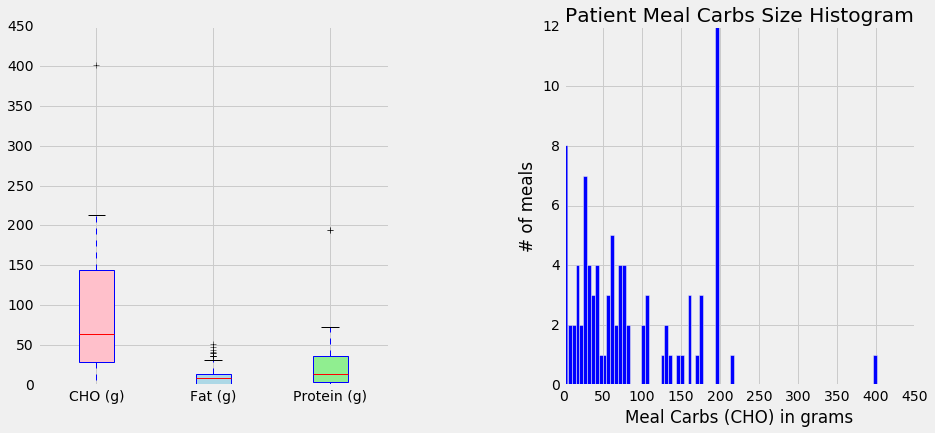

The meal Carbs mean is: 85.5954587308 grams with a std of: 74.1276671415 grams.

The meal Fat mean is: 11.7933920635 grams with a std of: 13.181200531 grams.

The meal Protein mean is: 22.50301746 grams with a std of: 30.764143884 grams.



In [64]:
bins =  int(math.ceil(np.max(df_P1_meals_w_deletion['CHO (g)'])/5))#bins of 5 grams

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# rectangular box plot
bplot1 = axes[0].boxplot([df_P1_meals_w_deletion['CHO (g)'],df_P1_meals_w_deletion['Fat (g)'], df_P1_meals_w_deletion['Protein (g)']],
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)

bplot0 = axes[1].hist(df_P1_meals_w_deletion['CHO (g)'], bins, facecolor='blue', alpha=1)
axes[1].set_xlabel('Meal Carbs (CHO) in grams')
axes[1].set_ylabel('# of meals')
axes[1].set_title('Patient Meal Carbs Size Histogram')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

    
    
# add x-tick labels
plt.setp(axes[0], xticks=[y+1 for y in range(3)],
         xticklabels=['CHO (g)', 'Fat (g)', 'Protein (g)'])

fig.subplots_adjust(wspace=0.5)

plt.show()

print "The meal Carbs mean is:", np.mean(df_P1_meals_w_deletion['CHO (g)']), "grams with a std of:", np.std(df_P1_meals_w_deletion['CHO (g)']), "grams.\n"
print "The meal Fat mean is:", np.mean(df_P1_meals_w_deletion['Fat (g)']), "grams with a std of:", np.std(df_P1_meals_w_deletion['Fat (g)']), "grams.\n"
print "The meal Protein mean is:", np.mean(df_P1_meals_w_deletion['Protein (g)']), "grams with a std of:", np.std(df_P1_meals_w_deletion['Protein (g)']), "grams.\n"

The current main dataframes are:

1. df_P1: it contains all patient data points as they were first imported from csv file

2. df_P1_meals_w_deletion: it contains all the recorded meals after removing the abnormal ones

3. surrounding_lowest_points_df: it contains the appropriate lowest points (points of increase) surrounding the recorded meal times.

4. peak_points_df: it contains the glucose peaks following the recorded meals

The glucose mean at the time of recorded meals is: 119.3 mg/dL with a std of: 18.822828929

The glucose mean at the time of lowest points surrounding the recorded meals is: 108.588888889 mg/dL with a std of: 15.5805394604

The time difference between recorded meals and the start of glucose increase is: 4.83333333333 minutes.


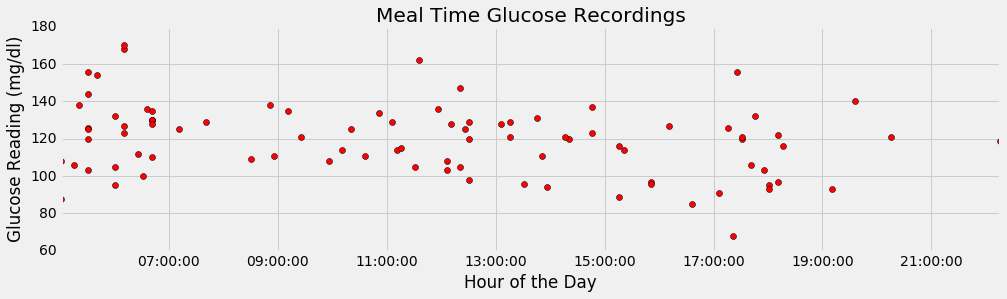

In [65]:
df_P1_all_clean_1day = copy.deepcopy(df_P1_meals_w_deletion)
df_1day_increasePoints = copy.deepcopy(surrounding_lowest_points_df)
df_1day_peakpoints = copy.deepcopy(peak_points_df)

d = datetime.datetime.today()
for i in range(len(df_P1_all_clean_1day)):
    dt = df_P1_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_P1_all_clean_1day.Date[i] = dt

fig = plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)

sub1 = fig.add_subplot(311)
sub1.set_xlabel('Hour of the Day')
sub1.set_ylabel('Glucose Reading (mg/dl)')
sub1.set_title('Meal Time Glucose Recordings')
plt.plot_date(df_P1_all_clean_1day.Date, df_P1_all_clean_1day['mg/dL'], 'ro')    

#############
#Plotting all increase points in one day
# for i in range(len(df_1day_increasePoints)):
#     dt = df_1day_increasePoints.Date[i].replace(year=d.year, month=d.month, day=d.day)    
#     df_1day_increasePoints.Date[i] = dt    
    
# sub2 = fig.add_subplot(312)
# sub2.set_xlabel('Hour of the Day')
# sub2.set_ylabel('Glucose Reading (mg/dl)')
# sub2.set_title('Increase Points nearby meals')
# plt.plot_date(df_1day_increasePoints.Date, df_1day_increasePoints['mg/dL'], 'bo')

#############
#Plotting all peak points in one day
# for i in range(len(df_1day_peakpoints)):
#     dt = df_1day_peakpoints.Date[i].replace(year=d.year, month=d.month, day=d.day)    
#     df_1day_peakpoints.Date[i] = dt    
    
# sub3 = fig.add_subplot(313)
# sub3.set_xlabel('Hour of the Day')
# sub3.set_ylabel('Glucose Reading (mg/dl)')
# sub3.set_title('Increase Points nearby meals')
# plt.plot_date(df_1day_peakpoints.Date, df_1day_peakpoints['mg/dL'], 'go')


print "The glucose mean at the time of recorded meals is:", np.mean(df_P1_meals_w_deletion['mg/dL']), "mg/dL with a std of:", np.std(df_P1_meals_w_deletion['mg/dL'])

print "\nThe glucose mean at the time of lowest points surrounding the recorded meals is:", np.mean(surrounding_lowest_points_df['mg/dL']), "mg/dL with a std of:", np.std(surrounding_lowest_points_df['mg/dL'])


print "\nThe time difference between recorded meals and the start of glucose increase is:", np.mean(offset_meal2increase), "minutes."

plt.show()

# Breakfast & Lunch & Dinner

In [66]:
#Dinner
Plot_extraction_v2(df_P1_meals_w_deletion, df_all_plots_v2)

breakfast_df = copy.deepcopy(df_all_plots_v2)
lunch_df = copy.deepcopy(df_all_plots_v2)
dinner_df = copy.deepcopy(df_all_plots_v2)

offset_breakfast2increase = copy.deepcopy(offset_meal2increase)
offset_lunch2increase = copy.deepcopy(offset_meal2increase)
offset_dinner2increase = copy.deepcopy(offset_meal2increase)

peak_elapsed_breakfast = copy.deepcopy(peak_elapsed_time)
peak_elapsed_lunch = copy.deepcopy(peak_elapsed_time)
peak_elapsed_dinner = copy.deepcopy(peak_elapsed_time)

breakfast_surrounding_lp_df = copy.deepcopy(surrounding_lowest_points_df)  
lunch_surrounding_lp_df = copy.deepcopy(surrounding_lowest_points_df) 
dinner_surrounding_lp_df = copy.deepcopy(surrounding_lowest_points_df) 

breakfast_peak_df = copy.deepcopy(peak_points_df)
lunch_peak_df = copy.deepcopy(peak_points_df)
dinner_peak_df = copy.deepcopy(peak_points_df)

breakfast_meals = []
breakfast_start_hour = 4
breakfast_max_hour = 10

lunch_meals = []
lunch_start_hour = 11
lunch_max_hour = 14

dinner_meals = []
dinner_start_hour = 16
dinner_max_hour = 23

remove_breakfast_x = []
remove_lunch_x = []
remove_dinner_x = []

for x in range(len(df_P1_meals_w_deletion)):
    a = df_P1_meals_w_deletion['Date'][x]
    meal_Date = df_P1.loc[df_P1['Date'] == a]['Date']
    meal_dt=meal_Date.values[0]
    mdt = datetime.datetime.utcfromtimestamp(meal_dt.astype('O')/(1e9))
    #print mdt.strftime('%H:%M:%S')
    meal_hr = mdt.strftime('%H')    
    #print int(meal_hr)
    if (int(meal_hr)>breakfast_max_hour or int(meal_hr)<breakfast_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        breakfast_meals.extend([x])
        remove_breakfast_x.append(x)
    
    if (int(meal_hr)>=lunch_max_hour or int(meal_hr)<lunch_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        lunch_meals.extend([x])    
        remove_lunch_x.append(x)
    
    if (int(meal_hr)>dinner_max_hour or int(meal_hr)<dinner_start_hour):
        #print "This does not belong to breakfast"
        #Drop all these data points that do not belong to breakfast period
        dinner_meals.extend([x])
        remove_dinner_x.append(x)

###############Breakfast
breakfast_df.drop(breakfast_df.index[breakfast_meals],axis=0,inplace=True)
breakfast_df = breakfast_df.reset_index(drop=True)  
print "This patient has", len(breakfast_df), "breakfast readings."

breakfast_surrounding_lp_df.drop(breakfast_surrounding_lp_df.index[breakfast_meals],axis=0,inplace=True)
breakfast_surrounding_lp_df = breakfast_surrounding_lp_df.reset_index(drop=True) 

breakfast_peak_df.drop(breakfast_peak_df.index[breakfast_meals],axis=0,inplace=True)
breakfast_peak_df = breakfast_peak_df.reset_index(drop=True)

for i in range(len(remove_breakfast_x)):
    index = remove_breakfast_x[i]
    del offset_breakfast2increase[index-i]
    del peak_elapsed_breakfast[index-i]

###############Lunch
lunch_df.drop(lunch_df.index[lunch_meals],axis=0,inplace=True)
lunch_df = lunch_df.reset_index(drop=True)  
print "This patient has", len(lunch_df), "lunch readings."

lunch_surrounding_lp_df.drop(lunch_surrounding_lp_df.index[lunch_meals],axis=0,inplace=True)
lunch_surrounding_lp_df = lunch_surrounding_lp_df.reset_index(drop=True) 

lunch_peak_df.drop(lunch_peak_df.index[lunch_meals],axis=0,inplace=True)
lunch_peak_df = lunch_peak_df.reset_index(drop=True)

for i in range(len(remove_lunch_x)):
    index = remove_lunch_x[i]
    del offset_lunch2increase[index-i]
    del peak_elapsed_lunch[index-i]

###############Dinner
dinner_df.drop(dinner_df.index[dinner_meals],axis=0,inplace=True)
dinner_df = dinner_df.reset_index(drop=True) 
print "This patient has", len(dinner_df), "dinner readings."

dinner_surrounding_lp_df.drop(dinner_surrounding_lp_df.index[dinner_meals],axis=0,inplace=True)
dinner_surrounding_lp_df = dinner_surrounding_lp_df.reset_index(drop=True) 

dinner_peak_df.drop(dinner_peak_df.index[dinner_meals],axis=0,inplace=True)
dinner_peak_df = dinner_peak_df.reset_index(drop=True)

for i in range(len(remove_dinner_x)):
    index = remove_dinner_x[i]
    del offset_dinner2increase[index-i]
    del peak_elapsed_dinner[index-i]
    
#dinner_df.describe()
#print len(dinner_df)

print_full (dinner_df)

#dinner_df.to_csv('Patient1_dinner_df.csv', sep='\t', encoding='utf-8')
dinner_df.to_csv('Patient1_dinner_df.csv', index=False)
lunch_df.to_csv('Patient1_lunch_df.csv', index=False)
breakfast_df.to_csv('Patient1_breakfast_df.csv', index=False)

This patient has 39 breakfast readings.
This patient has 22 lunch readings.
This patient has 20 dinner readings.
     -10    -5      0      5      10     15     20     25     30     35   \
0    90.0   91.0   93.0   94.0   96.0   97.0   99.0  101.0  103.0  105.0   
1   118.0  122.0  127.0  134.0  144.0  150.0  152.0  151.0  147.0  135.0   
2   114.0  115.0  120.0  121.0  120.0  121.0  124.0  123.0  125.0  131.0   
3    88.0   91.0   91.0   96.0   99.0  102.0  108.0  106.0  104.0  100.0   
4    91.0   94.0   97.0   98.0   99.0  101.0  107.0  113.0  118.0  120.0   
5   113.0  113.0  116.0  119.0  120.0  120.0  122.0  121.0  128.0  125.0   
6   128.0  126.0  126.0  128.0  128.0  138.0  147.0  159.0  161.0  165.0   
7   178.0  170.0  156.0  159.0  159.0  156.0  147.0  140.0  155.0  148.0   
8    93.0   83.0   68.0   63.0   63.0   60.0   61.0    NaN    NaN    NaN   
9   121.0  121.0  119.0  122.0  113.0   97.0   83.0   88.0   86.0   84.0   
10   94.0   93.0   95.0   98.0  102.0  108.0  111.0

In [67]:
def Plot_Period(period_to_plot, surrounding_lowpts_df, offset_to_increase, peaks_df, peaks_offset):

    period_df = copy.deepcopy(period_to_plot)
    surrounding_lp_df = copy.deepcopy(surrounding_lowpts_df)
    offset2increase = copy.deepcopy(offset_to_increase)
    peak_pts_df = copy.deepcopy(peaks_df)
    peak_elapsed_t = copy.deepcopy(peaks_offset)
    
    plt.figure(figsize=(20,12))
    for j in range(0,5):
    #for j in range(len(dinner_df)):
        row = period_df.iloc[j]
        row.plot()
        #row.plot(label='Meal Time at {}'.format(df_P1_w_all_deletion['Date'][j]))
        #Recorded meal time reading
        plt.plot(0, period_df[0][j], 'ro', markersize=10)
        #Lowest surrounding point of increase
        plt.plot(offset2increase[j], surrounding_lp_df['mg/dL'][j], 'b^', markersize=15)
        plt.plot(peak_elapsed_t[j], peak_pts_df['mg/dL'][j], 'y*', markersize=20) 

    plt.xlabel('Minutes')
    plt.ylabel('Glucose Reading (mg/dl)')
    #plt.legend(loc='upper right')
    title = 'Glucose Lelvel Readings {} minutes after meal recording or until next meal recording'.format(after_reading)
    plt.title(title)

    plt.show()

Plotting of segmented after meal plots for Breakfast


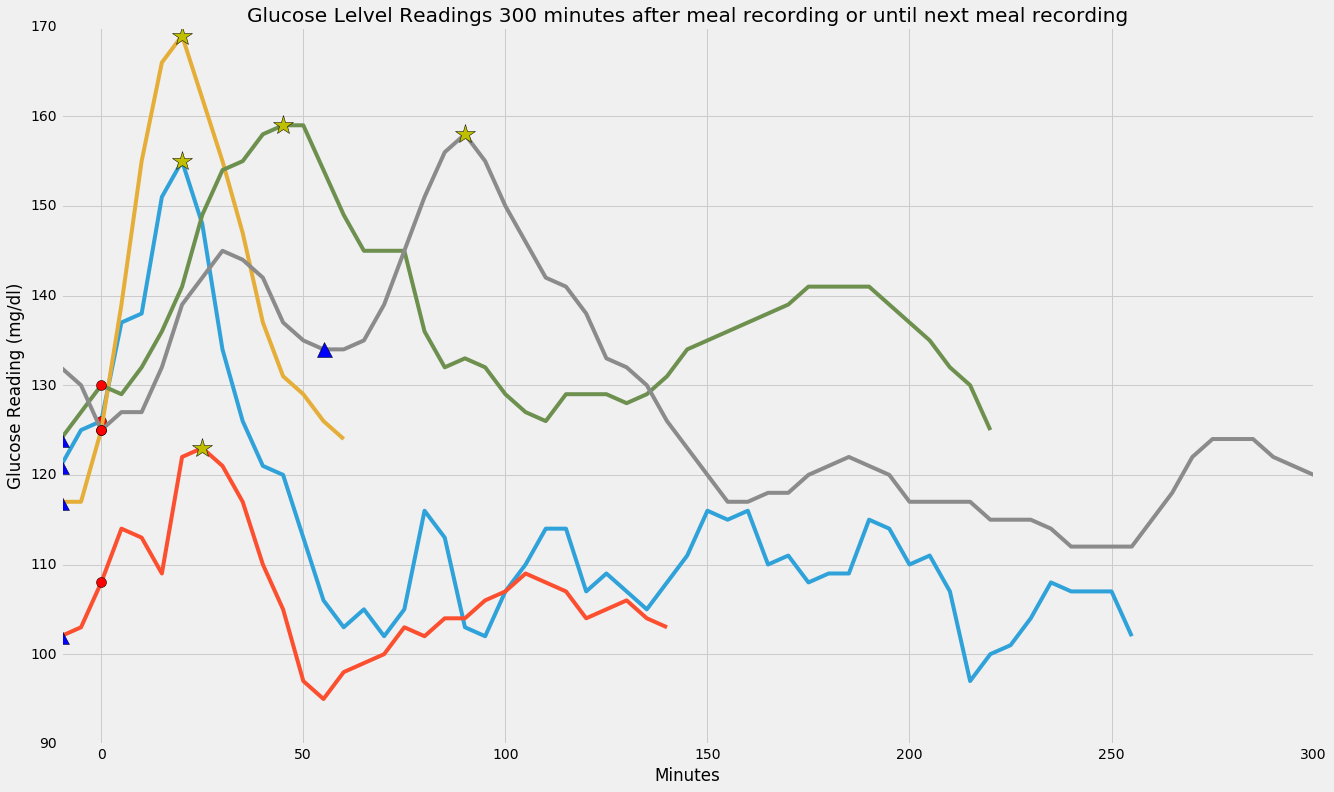

Plotting of segmented after meal plots for Lunch


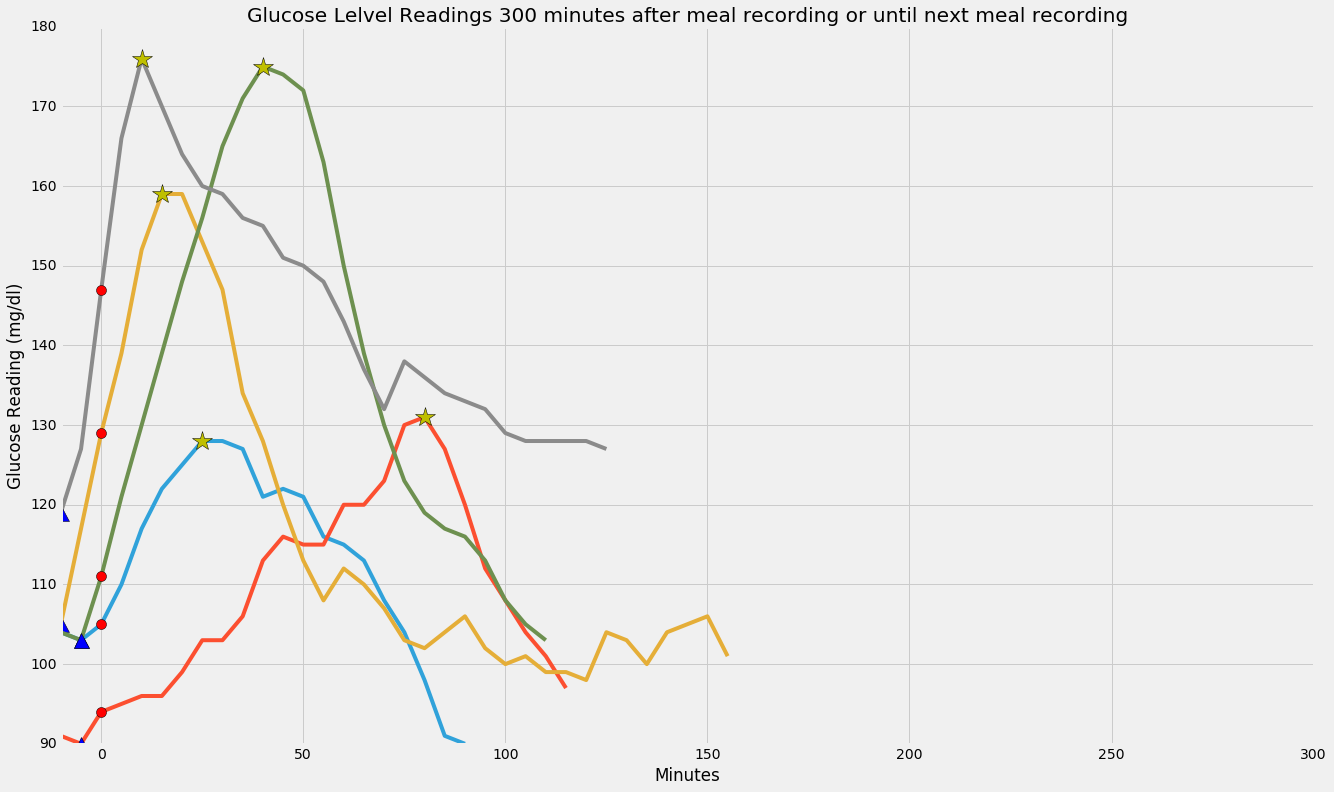

Plotting of segmented after meal plots for Dinner


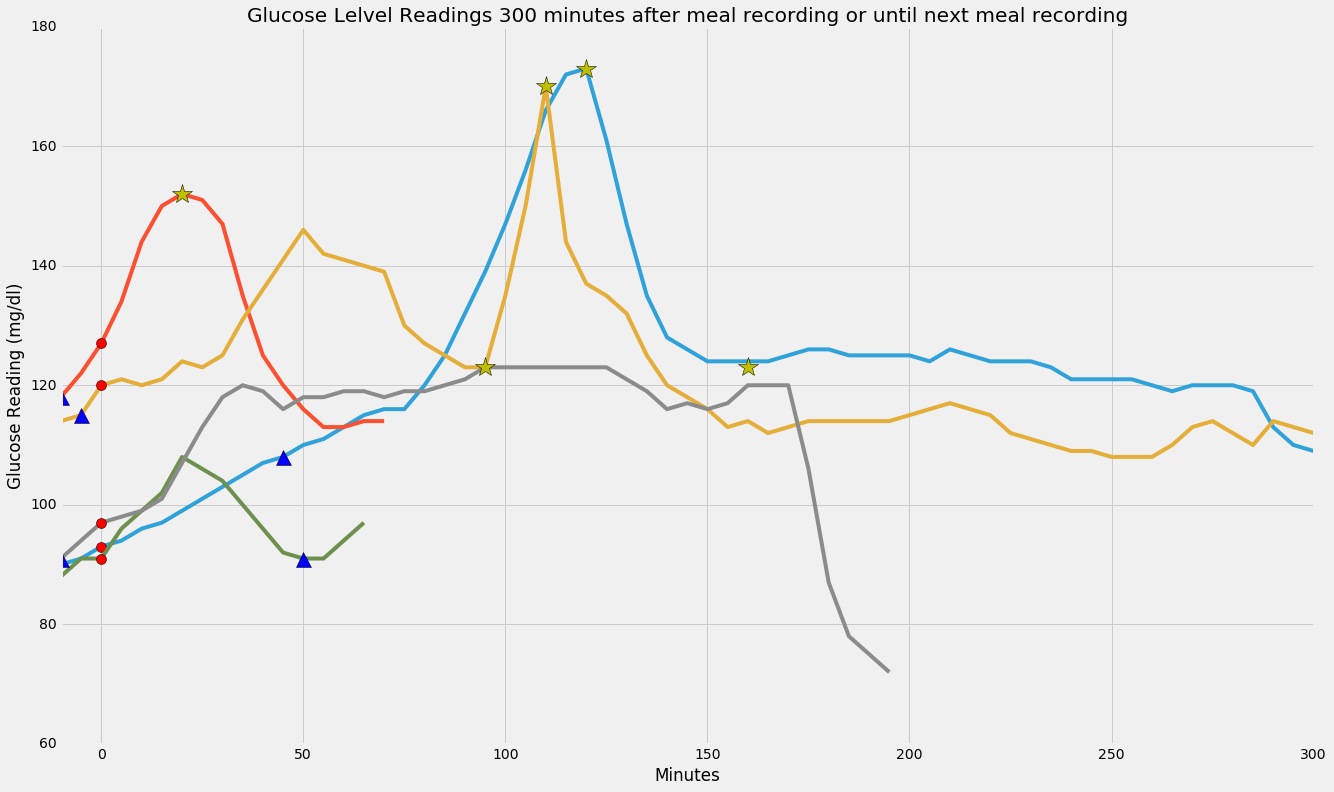

In [68]:
#Plot any preriod by replacing period_df by the desired period,
#arg1 is breakfast_df or lunch_df or dinner_df
#arg2 is breakfast_surrounding_lp_df, lunch_surrounding_lp_df, dinner_surrounding_lp_df 
#arg3 is offset_breakfast2increase, offset_lunch2increase, offset_dinner2increase 
#arg4 is breakfast_peak_df, lunch_peak_df, dinner_peak_df
#arg5 is peak_elapsed_breakfast, peak_elapsed_lunch, peak_elapsed_dinner

print "Plotting of segmented after meal plots for Breakfast"
Plot_Period(breakfast_df,breakfast_surrounding_lp_df, offset_breakfast2increase, breakfast_peak_df, peak_elapsed_breakfast)

print "Plotting of segmented after meal plots for Lunch"
Plot_Period(lunch_df,lunch_surrounding_lp_df, offset_lunch2increase, lunch_peak_df, peak_elapsed_lunch)

print "Plotting of segmented after meal plots for Dinner"
Plot_Period(dinner_df,dinner_surrounding_lp_df, offset_dinner2increase, dinner_peak_df, peak_elapsed_dinner)



In [69]:
import numpy

# print "The number of dinner recording are", len(dinner_df)

# #print (dinner_df.iloc[0])

# dinner_row = []
# index_dinner_row = []
# dinner_pts = []

# dinner_row = dinner_df.iloc[0:len(dinner_df)]
# # print dinner_row

# max_index = (after_reading+pre_recording_mins)/5
# full_plot_indeces = map(lambda v : v * 5, range(max_index))
# for x in range(len(dinner_df)):   
#     for i,j in enumerate(dinner_row.iloc[x]):
#         if(numpy.isnan(j)):
#             if (i > (pre_recording_mins/5)):
#                 if (i < max_index):
#                     max_index = i
#         else:
#             dinner_pts.append(j)
#             index_dinner_row.append(i)

# print "Plot the values until the following minute", (max_index*5 - 5)
# plot_indeces = map(lambda v : v * 5, range(max_index))


# print plot_indeces
        
# x = index_dinner_row   
# y = dinner_pts

# x_new = map(lambda v : v * 5, index_dinner_row)

# p = numpy.poly1d(numpy.polyfit(x_new, y, deg=15))

# print "\nThe polynomial fitting the data is:\n\n",p

# fig1 = plt.figure(figsize=(20,15))  

# ax1 = fig1.add_subplot(211)                                                                                                                                                       
# ax1.plot(x_new, dinner_pts, '.', markersize=10) 
# ax1.set_title('Original Meal Plot')


# ax2 = fig1.add_subplot(212)   
# #Up to smallest plot window
# #ax2.plot(plot_indeces, p(plot_indeces)) 
# #or the full window
# ax2.plot(full_plot_indeces, p(full_plot_indeces))   
# ax2.set_title('Curve fitted Meal Plot')

                                                                    
# plt.show()

In [70]:
def curvefit(meal_df):
    print "The number of recordings are", len(meal_df)

    meal_row = []
    index_meal_row = []
    meal_pts = []
    meal_glucose = []
    meal_row = meal_df.iloc[0:len(meal_df)]

    #Plottinh until the below max index, after reading window for instance is 300 minutes
    max_index = (after_reading-100)/5

    
    for a in range(len(meal_df)):
        #calculate glucose mean at meal time recording for all days in same period
        meal_glucose.extend([meal_row.iloc[a][0]])
    print "The mean of glucose level at meal recording is:", np.mean(meal_glucose), "mg/dL with a std of", np.std(meal_glucose)
   
    
    for k in range(len(meal_df)):   
        for i,j in enumerate(meal_row.iloc[k]):
            if(numpy.isnan(j)):
                if (i > (pre_recording_mins/5)):
                    if (i < max_index):
                        continue
                        #max_index = i
                        #print "for the iteration k is", k, "the max index is:", max_index
                        #break
            else:
                meal_pts.append(j)
                index_meal_row.append(i)
                
    print "Plot the values until the following minute", (max_index*5 - 5)
    plot_indeces = map(lambda v : v * 5, range(max_index))

    print plot_indeces

    x = index_meal_row   
    y = meal_pts
    
    full_plot_indeces = map(lambda v : v * 5, range(max_index))
    
    x_new = map(lambda v : v * 5, index_meal_row)

    p = numpy.poly1d(numpy.polyfit(x_new, y, deg=10))

    print "\nThe polynomial fitting the data is:\n\n",p

    fig1 = plt.figure(figsize=(20,15))  

    ax1 = fig1.add_subplot(211)                                                                                                                                                       
    ax1.plot(x_new, meal_pts, '.', markersize=10) 
    ax1.set_title('Original Meal Plot')


    ax2 = fig1.add_subplot(212)   
    #Up to smallest plot window
    #ax2.plot(plot_indeces, p(plot_indeces)) 
    #or the full window
    ax2.plot(full_plot_indeces, p(full_plot_indeces))   
    ax2.set_title('Curve fitted Meal Plot')

    plt.show()

The number of recordings are 39
The mean of glucose level at meal recording is: 124.58974359 mg/dL with a std of 18.1513832894
Plot the values until the following minute 195
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]

The polynomial fitting the data is:

           10             9            8             7             6
8.865e-20 x  - 1.436e-16 x + 9.91e-14 x - 3.795e-11 x + 8.805e-09 x
              5             4            3          2
 - 1.267e-06 x + 0.0001106 x - 0.005404 x + 0.1167 x - 0.1241 x + 118.6


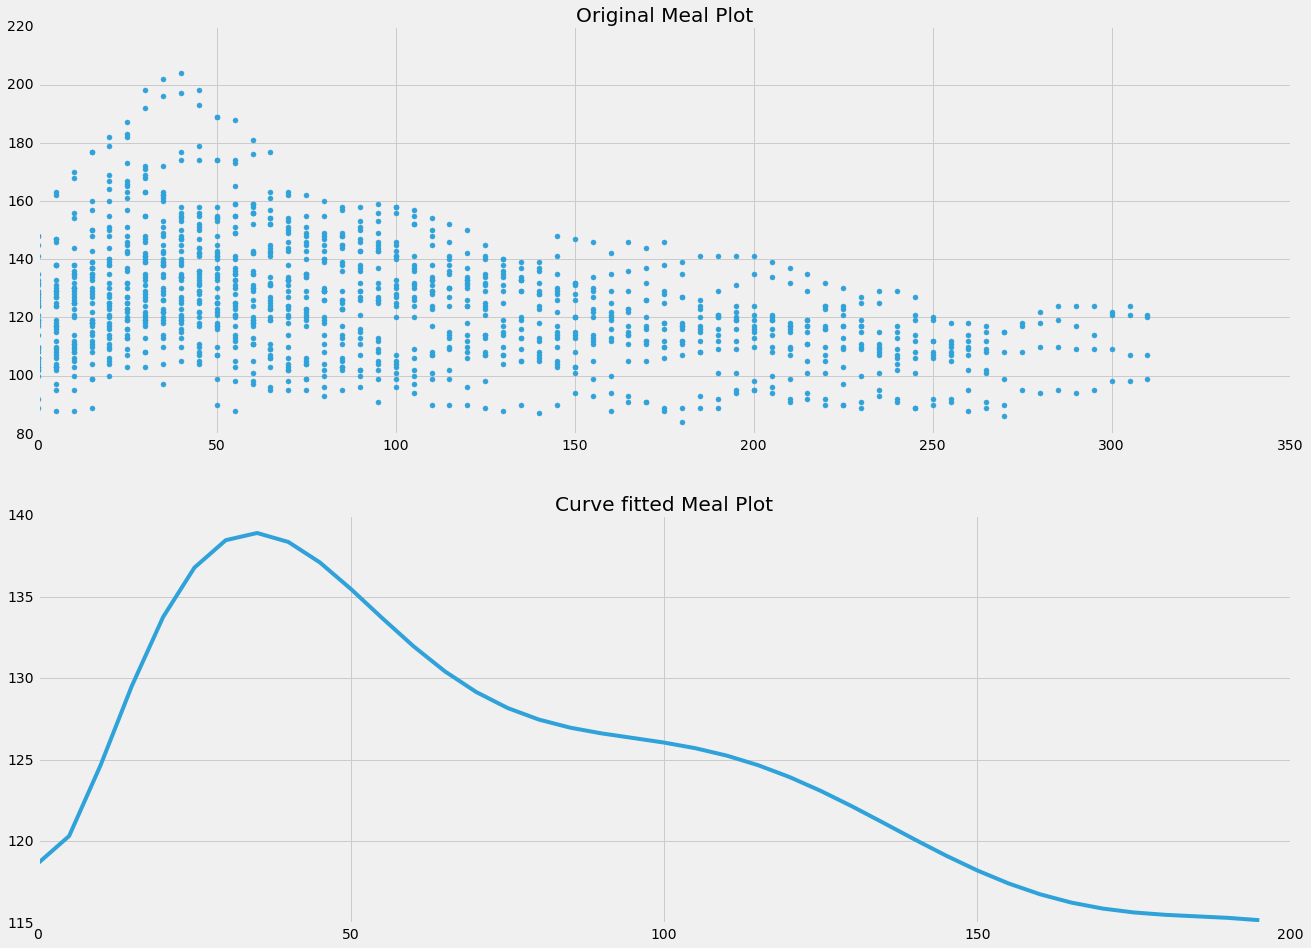

In [71]:
curvefit(breakfast_df)

The number of recordings are 22
The mean of glucose level at meal recording is: 119.727272727 mg/dL with a std of 16.5506984697
Plot the values until the following minute 195
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]

The polynomial fitting the data is:

           10             9             8             7             6
7.969e-20 x  - 1.127e-16 x + 6.621e-14 x - 2.087e-11 x + 3.796e-09 x
              5             4             3           2
 - 3.971e-07 x + 2.181e-05 x - 0.0003911 x - 0.01731 x + 0.9216 x + 113.4


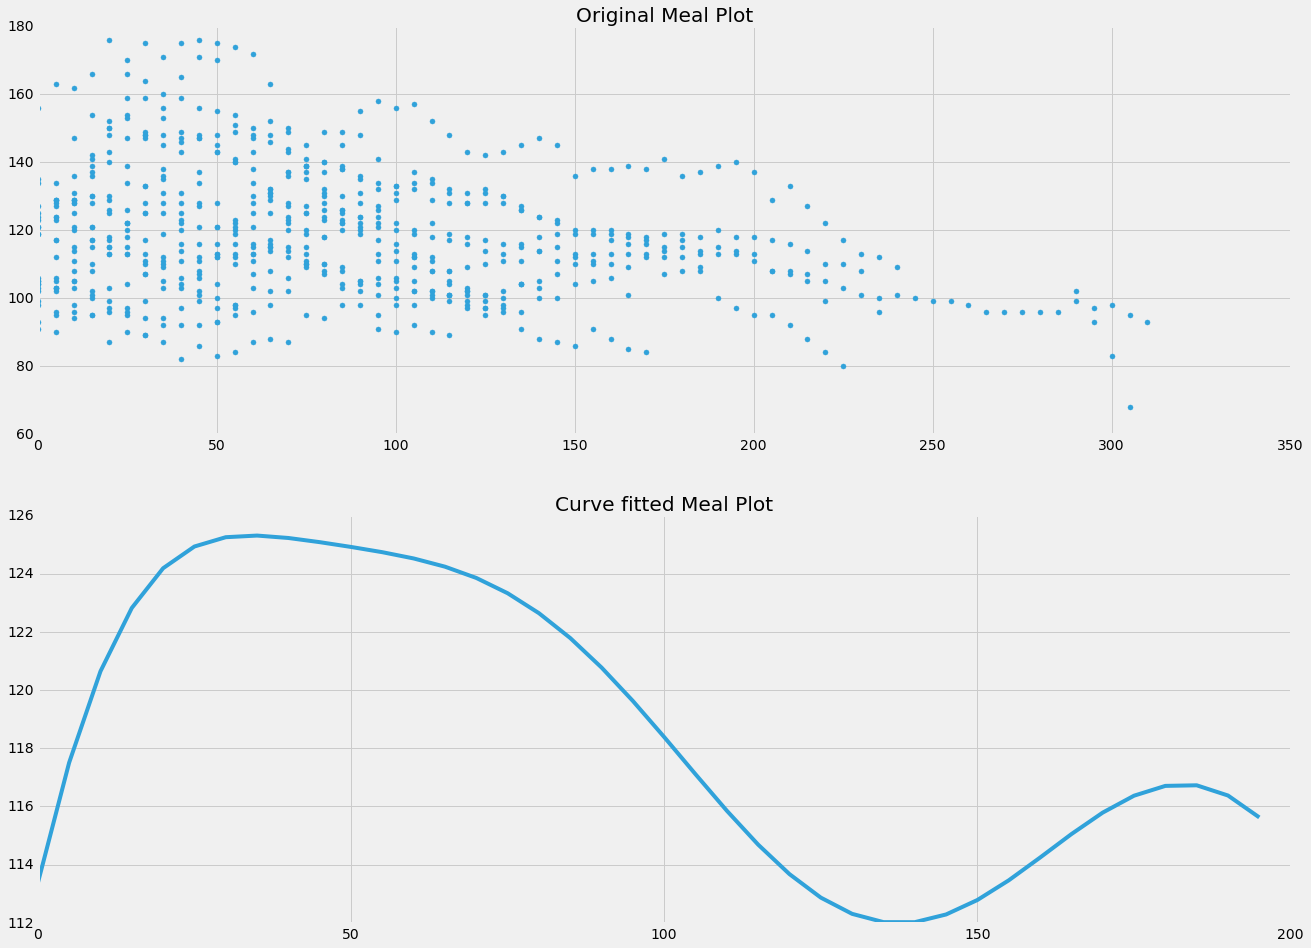

In [72]:
curvefit(lunch_df)

The number of recordings are 20
The mean of glucose level at meal recording is: 111.55 mg/dL with a std of 20.4779759742
Plot the values until the following minute 195
[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]

The polynomial fitting the data is:

           10           9             8             7             6
4.231e-20 x  - 7.7e-17 x + 5.923e-14 x - 2.513e-11 x + 6.429e-09 x
              5             4            3          2
 - 1.015e-06 x + 9.705e-05 x - 0.005269 x + 0.1397 x - 0.9519 x + 110.8


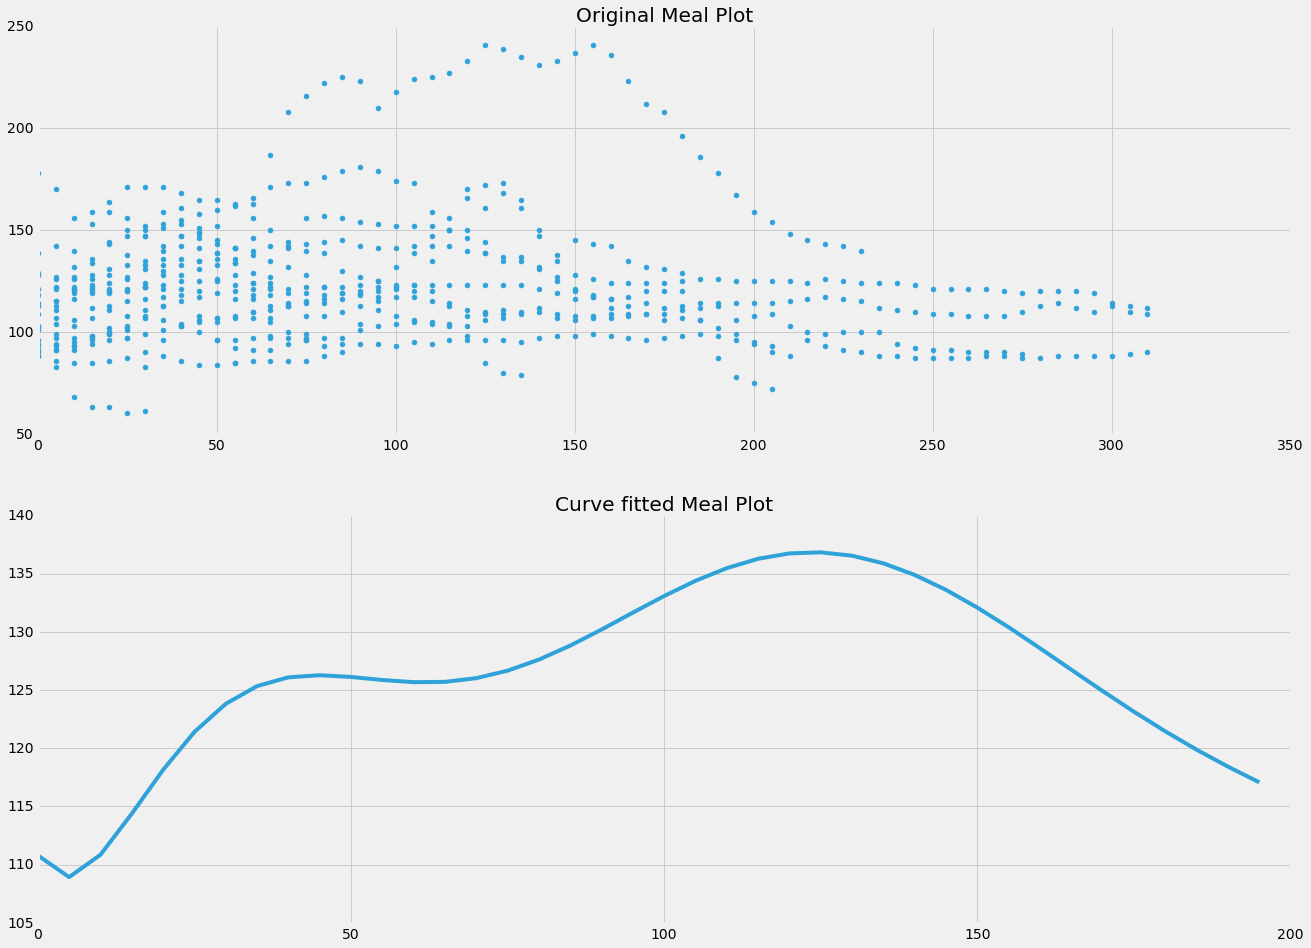

In [73]:
curvefit(dinner_df)

# Plot fitted curves after each meal

In [74]:
#Always remember df[i][j], i is the column and j is row

In [75]:
def allmealscurvefitted(input_df):
    output_df = pd.DataFrame()
    
    meal_df = copy.deepcopy(input_df)

    print "The number of plots are", meal_df.shape[0]

    meal_row = []
    index_meal_row = []
    meal_pts = []

    meal_row = meal_df.iloc[0:len(meal_df)]

    coeff_df = pd.DataFrame()

    plt.figure(figsize=(20,15)) 

    for k in range (len(meal_df)): 
        max_index = (after_reading)/5
        for i,j in enumerate(meal_row.iloc[k]):
            if(numpy.isnan(j)):
                if (i > (pre_recording_mins/5)):
                    if (i < max_index):
                        max_index = i
            else:
                meal_pts.append(j)
                index_meal_row.append(i)

        #print "\n\nPlot the values until the", (max_index*5 - 5), "minute after the meal"
        plot_indeces = map(lambda v : v * 5, range(max_index))

        #print plot_indeces
        full_plot_indeces = map(lambda v : v * 5, range(max_index))
        x = index_meal_row   
        y = meal_pts

        x_new = map(lambda v : v * 5, index_meal_row)
        
        poly_deg = 10
        z = numpy.polyfit(x_new, y, deg=poly_deg)
        p = numpy.poly1d(z)

        #print "\nThe polynomial equation for fitting the data of points after meal is:\n\n",p

        #print p(full_plot_indeces)

        plt.plot(full_plot_indeces, p(full_plot_indeces)) 
        
        #This dataframe have the polynomial coeffecients in every row
        coeff_df[k] = z
        
    coeff_df_copy1 = copy.deepcopy(coeff_df) 

    #####Plotting the average glucose plot of them all
    coeff_df['mean'] = coeff_df.mean(axis=1)
    
    #print coeff_df
    
    pofz = numpy.poly1d(coeff_df['mean'])

    max_index = (after_reading/2)/5
    full_plot_indeces = map(lambda v : v * 5, range(max_index))
    
    plt.plot(full_plot_indeces, pofz(full_plot_indeces),color='k', label = 'Fitted Curve of All') 
    #plt.show()
    
    #avg_plot_values = pofz(full_plot_indeces)     
    #print avg_plot_values
    
    plt.show()

# Breakfast all meal plotting

The number of plots are 39


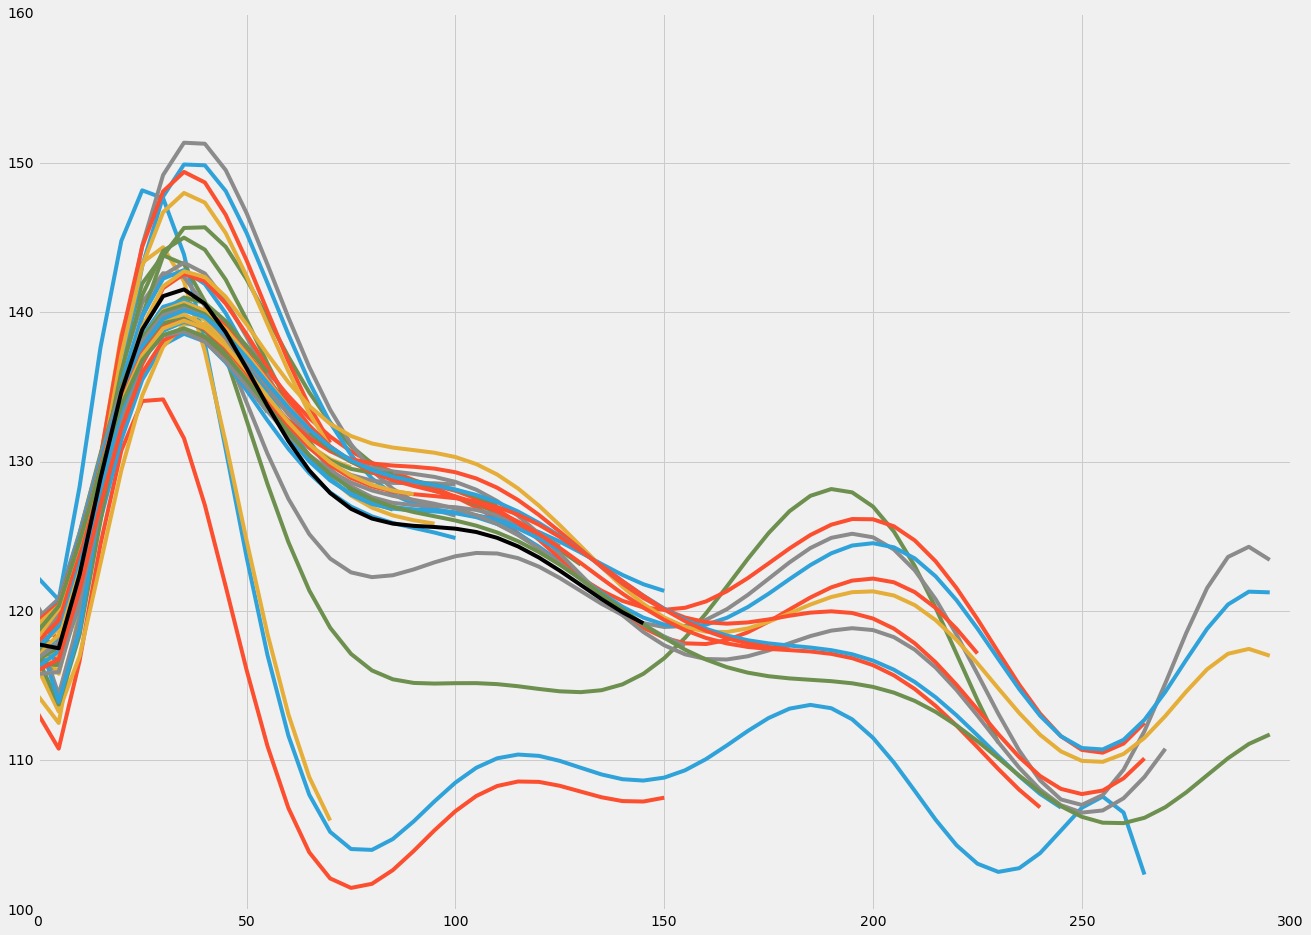

In [76]:
allmealscurvefitted(breakfast_df)

# Lunch all meal plotting

The number of plots are 22


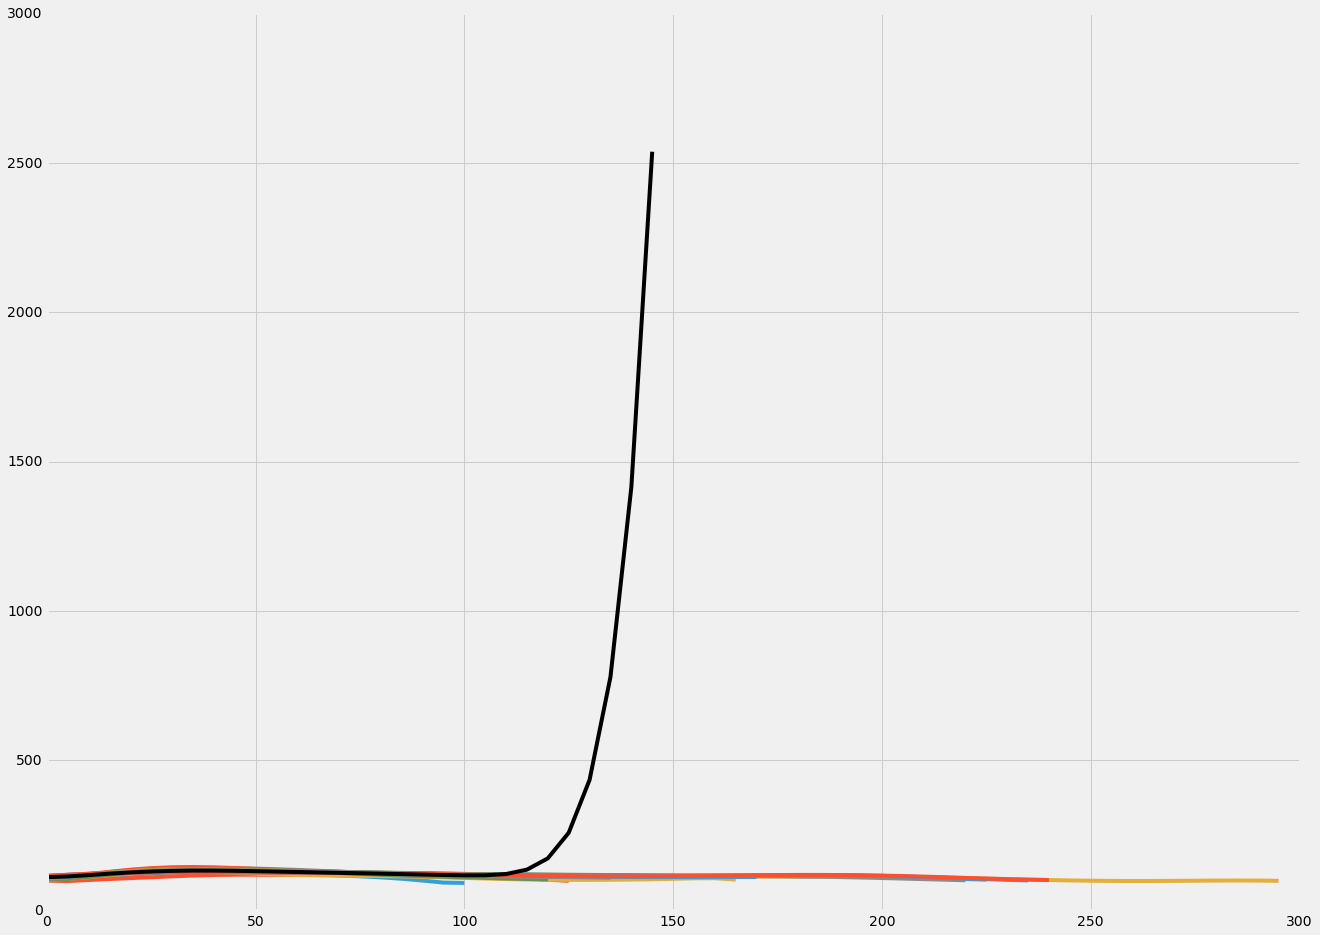

In [77]:
allmealscurvefitted(lunch_df)

# Dinner all meal plotting

The number of plots are 20


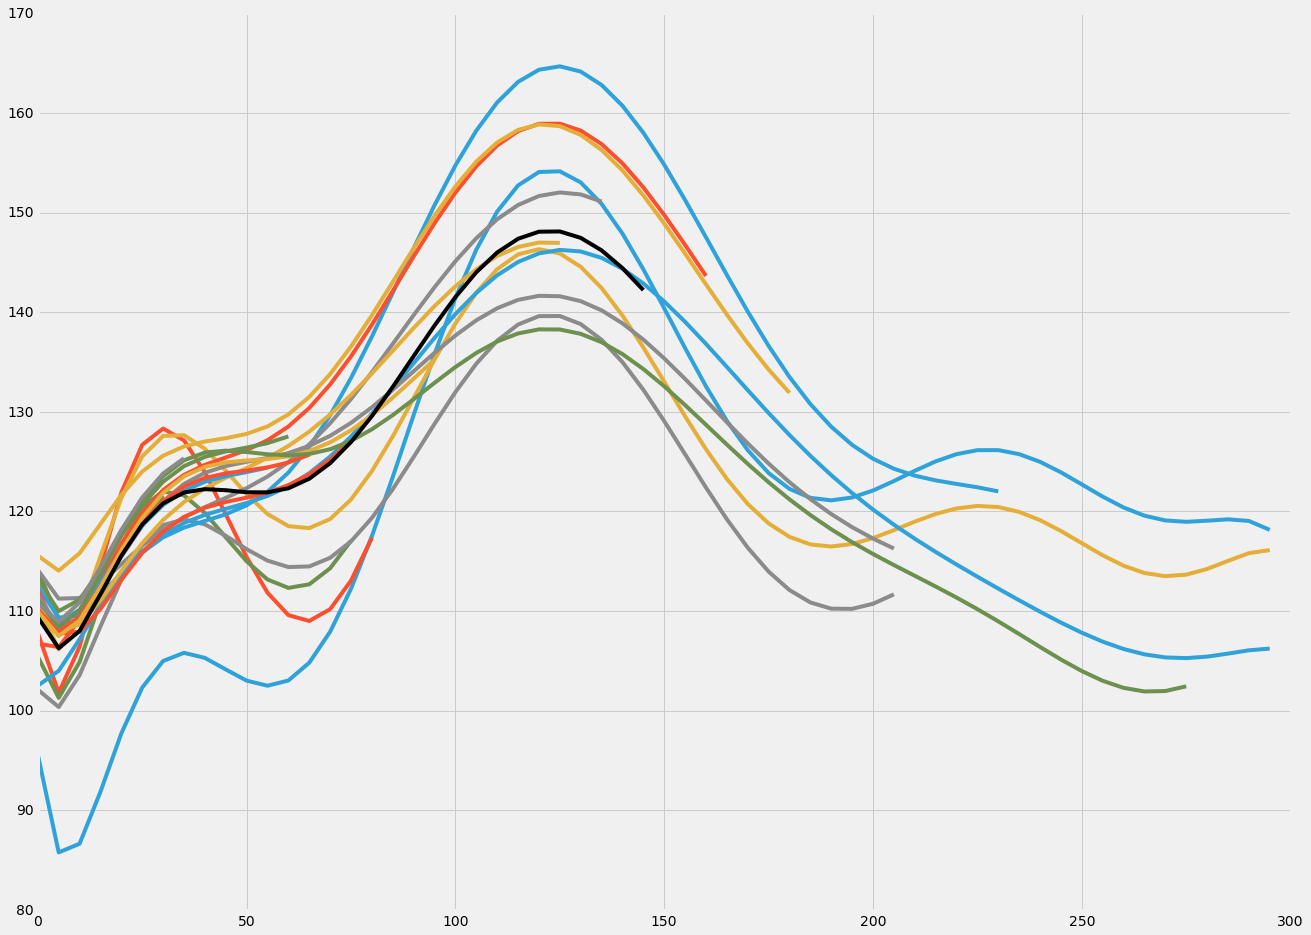

In [78]:
allmealscurvefitted(dinner_df)